In [7]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from matplotlib.lines import Line2D
from collections import Counter
from nameparser import HumanName
import gender_guesser.detector as gender
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"


# Valid Years
years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

In [9]:
def plot_roc_and_confusion_matrix(df, threshold):
    # True labels: whether the institution has a female president (1 = True, 0 = False)
    y_true = df['female_president'].astype(int)  # Convert boolean to 0/1
    
    # Predicted scores: proportion of females on the board
    y_scores = df['female'] / df[['female', 'male', 'unknown']].sum(axis=1)
    
    # Ensure no division by zero
    y_scores = y_scores.fillna(0)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    J = tpr - fpr

    # Find the index of the maximum J
    ix = np.argmax(J)

    # Optimal threshold
    optimal_threshold = thresholds[ix]
    optimal_J = J[ix]

    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum Youden's J Statistic: {optimal_J:.2f}")
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Predicting Female President')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"AUC: {roc_auc:.2f}")
    
    # Threshold-based classification: Convert predicted scores into binary predictions
    y_pred = np.where(y_scores >= threshold, 1, 0)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Female President', 'Female President'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix at Threshold = {threshold}')
    plt.grid(False)
    plt.show()

    # Print confusion matrix details
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion Matrix at Threshold = {threshold}:")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")


In [10]:
def remove_non_samples(df):
    df = df[df['PrimarySample'] == True]
    return df

Optimal Threshold: 0.27
Maximum Youden's J Statistic: 0.23


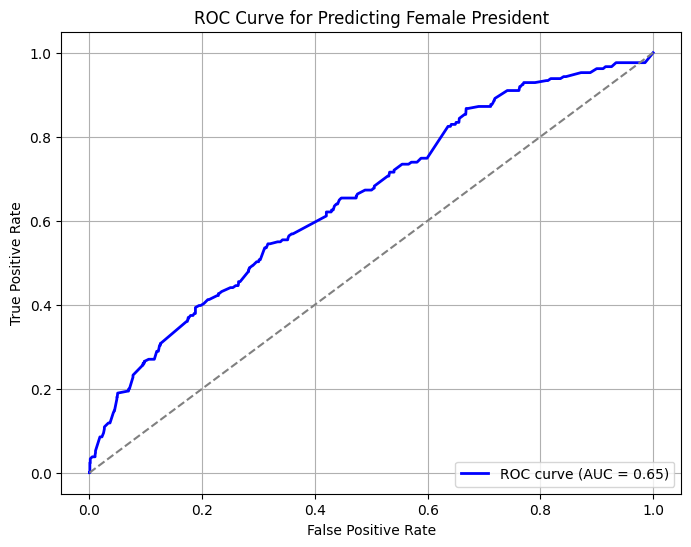

AUC: 0.65


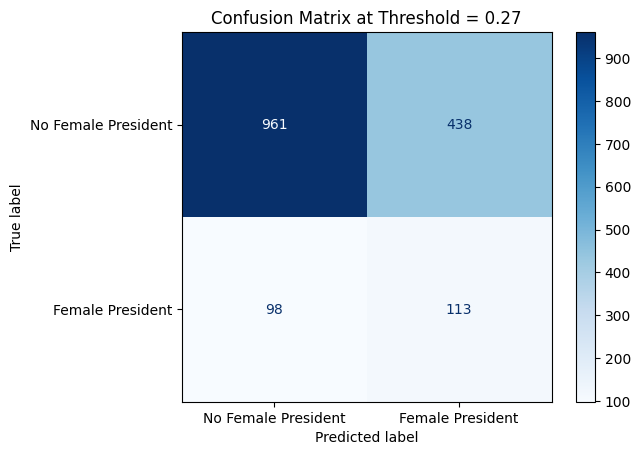

Confusion Matrix at Threshold = 0.27:
True Negatives:  961
False Positives: 438
False Negatives: 98
True Positives:  113


In [11]:
diversity_df = pd.read_csv(f"{altered_dataframe_path}sample_board_statistics.csv")
diversity_df = remove_non_samples(diversity_df)
plot_roc_and_confusion_matrix(diversity_df, threshold=0.27)

In [12]:

# Define the optimal threshold for female proportion
optimal_threshold = 0.27

# Assuming 'diversity_df' contains the data
# y_true: actual female president (already exists in your df)
y_true = diversity_df['female_president'].astype(int)

# y_scores: proportion of females on the board
y_scores = diversity_df['female'] / (diversity_df['female'] + diversity_df['male'] + diversity_df['unknown'])

# Create predicted female president column based on the optimal threshold
diversity_df['predicted_female_president'] = np.where(y_scores >= optimal_threshold, 1, 0)

# Create a contingency table for Chi-Square test
# This compares actual female president with predicted female president based on board proportions
contingency_table = pd.crosstab(diversity_df['female_president'], diversity_df['predicted_female_president'])

# Run the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected}")

Chi-Square Test Results:
Chi-Square Statistic: 39.326527595206144
P-Value: 3.5853704231164657e-10
Degrees of Freedom: 1
Expected Frequencies:
[[920.21180124 478.78819876]
 [138.78819876  72.21180124]]
